This is a final project for the course STA410. The project aims to perform anomaly detection within simple system log events using Hidden Markov Models, Log-Likelihoods, and Z-scores.

In [171]:
import scipy as sc
import numpy as np
import random
!pip install simpy
import simpy as sp
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Simulating the System User Log Events Sequences using SimPy

In [180]:
NORMAL_EVENTS = ["file_access", "process_start", "network_request",
    "print_document", "open_application", "save_file", "email_sent", "calendar_event_created",
    "drive_mount", "clipboard_copy", "clipboard_paste", "settings_viewed", "folder_created",
    "tab_switched", "browser_opened", "form_submitted", "search_query", "notification_dismissed",
    "screen_locked", "screen_unlocked", "update_checked", "vpn_connected", "usb_connected",
    "idle_timeout", "desktop_icon_clicked", "screenshot_taken", "password_entered", "window_minimized", "password_changed", "permission_request"]

ABNORMAL_EVENTS = ["unauthorized_file_access", "inappropriate_searches", "data_exfiltration", "access_restricted_area",
    "usb_file_transfer", "disabled_antivirus", "multiple_failed_logins", "download_torrent",
    "privilege_escalation", "disabled_firewall", "remote_desktop_started",
    "shadow_copy_deleted", "unauthorized_process", "unusual_data_volume",
    "external_backup_created", "suspicious_registry_edit", "hidden_file_created", "encoded_email_sent",
    "executable_downloaded", "log_cleared", "system_time_changed", "ransomware_alert",
    "suspicious_macro_execution", "encrypted_container_mounted", "unauthorized_command_prompt",
    "malicious_script_executed", "rootkit_detected", "browser_exploit_triggered", "fake_cert_installed", "unknown_device_connected"]

USERS = ["dign6", "aliv9", "vinc1", "manj7","ritd0", "tond3", "gana4", "gian2", "shaw5", "lore8", "mexa4", "zoti3", "japu1", "vilo8", "dare6", "soqi9", "teza0", "boku7", "rima5", "nely2",
    "waro6", "xipa0", "guto3", "cenu9", "lira1", "pemo8", "hika7", "dofu4", "moxa2", "yave5"]

class System:

    """
    ------ Attributes ------
    env: SimPy Environment
    (int) shift_end: The time when the shift ends.
    (list) log: List of logged system events. Events are in a tuple of (timestamp, event).
    (list) users: Registered users.
    (dict) user_activity: Users and their log events at the time performed.

    """

    def __init__(self, env, user_ids, shift_end_time):
        self.env = env
        self.shift_end = env.timeout(shift_end_time)
        self.log = []
        self.users = user_ids
        self.user_activity = {}

        random.shuffle(self.users)

        for user_id in self.users:
            env.process(self.user_session(user_id))

    def record_user_activity(self, user_id, activity, timestamp):
        """
        Records the user activity.
        """
        if user_id not in self.user_activity:
            self.user_activity[user_id] = [f"{activity} at time {timestamp}"]
        else:
            self.user_activity[user_id].append(f"{activity} at time {timestamp}")

    def user_session(self, user_id):
        """
        Entire session of a user. Randomly choose an amount of actions to take, and perform that amount of the normal events.

        """
        timestamp = self.env.now

        self.log_event(timestamp, f"User {user_id} logged in", user_id)

        # simulate random user activity
        for _ in range(random.randint(10, 30)):  # Perform 10-30 actions
            if random.random() < 0.20: # 20% chance user will do an anomalous activity
                yield self.env.timeout(random.randint(2,5)) # pause the simulation and function for a random time between 2-5
                event = random.choice(ABNORMAL_EVENTS)
                timestamp = self.env.now
                self.log_event(timestamp, f"User {user_id} {event}", user_id)

            yield self.env.timeout(random.randint(1,3)) # pause the simulation and function for a random time between 1-3
            event = random.choice(NORMAL_EVENTS)
            timestamp = self.env.now
            self.log_event(timestamp, f"User {user_id} {event}", user_id)

        yield self.shift_end # user sessions will stop once their shift is over and they log out
        timestamp = self.env.now
        self.log_event(timestamp, f"User {user_id} logged out", user_id)

    def log_event(self, timestamp, event, user_id):
        """
        Logs a system event.
        """
        self.log.append((timestamp, event))
        self.record_user_activity(user_id, event, timestamp)


## Run the Simulation

In [181]:
# set up the simulation
WORK_TIME = 40
env = sp.Environment()
system = System(env, USERS, WORK_TIME)

env.run() # runs the simulation

for user in system.user_activity: # lists what each user did
    print(f"{user}:")
    for event in system.user_activity[user]:
        print(f" - {event}")

rima5:
 - User rima5 logged in at time 0
 - User rima5 executable_downloaded at time 4
 - User rima5 browser_opened at time 5
 - User rima5 password_entered at time 6
 - User rima5 clipboard_copy at time 7
 - User rima5 drive_mount at time 9
 - User rima5 calendar_event_created at time 12
 - User rima5 idle_timeout at time 13
 - User rima5 access_restricted_area at time 15
 - User rima5 folder_created at time 16
 - User rima5 fake_cert_installed at time 19
 - User rima5 screen_locked at time 21
 - User rima5 idle_timeout at time 22
 - User rima5 unknown_device_connected at time 25
 - User rima5 window_minimized at time 26
 - User rima5 screen_locked at time 29
 - User rima5 browser_opened at time 30
 - User rima5 idle_timeout at time 32
 - User rima5 encoded_email_sent at time 37
 - User rima5 usb_connected at time 40
 - User rima5 window_minimized at time 41
 - User rima5 file_access at time 43
 - User rima5 save_file at time 44
 - User rima5 logged out at time 44
dare6:
 - User dare6

##  Train HMM on Normal Log Sequences


In [182]:
# convert system events to numbers for HMM to learn

all_events = NORMAL_EVENTS + ABNORMAL_EVENTS

encoder = LabelEncoder()
encoder.fit(all_events)

user_sequences = defaultdict(list)

for timestamp, raw_event in system.log:
    parts = raw_event.split(" ", 2)
    if len(parts) == 3:
        _, user, event = parts
        if event in all_events:
            user_sequences[user].append(event)

# want to train HMM on only normal sequences

normal_user_sequences = {
    user: [event for event in seq if event in NORMAL_EVENTS] for user, seq in user_sequences.items()
}

encoded_normal_sequences = {
    user: encoder.transform(seq) for user, seq in normal_user_sequences.items()
}

# train HMM on the normal sequences

X = np.concatenate([np.array(seq).reshape(-1, 1) for seq in encoded_normal_sequences.values()])

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

lengths = [len(seq) for seq in encoded_normal_sequences.values()]
total_samples = sum(lengths)

model = GaussianHMM(n_components=5)
model.fit(X_normalized, lengths=lengths)


GaussianHMM(n_components=5)

## Scoring New Sequences Using Log-Likelihood

In [183]:
# get all user scores to compare

all_encoded_sequences = {
    user: encoder.transform(seq) for user, seq in user_sequences.items()
}

all_X = np.concatenate([np.array(seq).reshape(-1, 1) for seq in all_encoded_sequences.values()])
all_X_normalized = scaler.transform(all_X)

# score users using log-likelihood, a higher (less negative) score means the user behaviour looks normal, and much lower (very negative) score means it is abnormal

user_scores = {}
log_likelihoods = []
index = 0
for user, seq in all_encoded_sequences.items():
    seq_normalized = all_X_normalized[index:index+len(seq)].reshape(-1, 1)
    user_scores[user] = model.score(seq_normalized)
    log_likelihoods.append(user_scores[user])
    index += len(seq)

## Plot for Visualizing Sequences and State Predictions

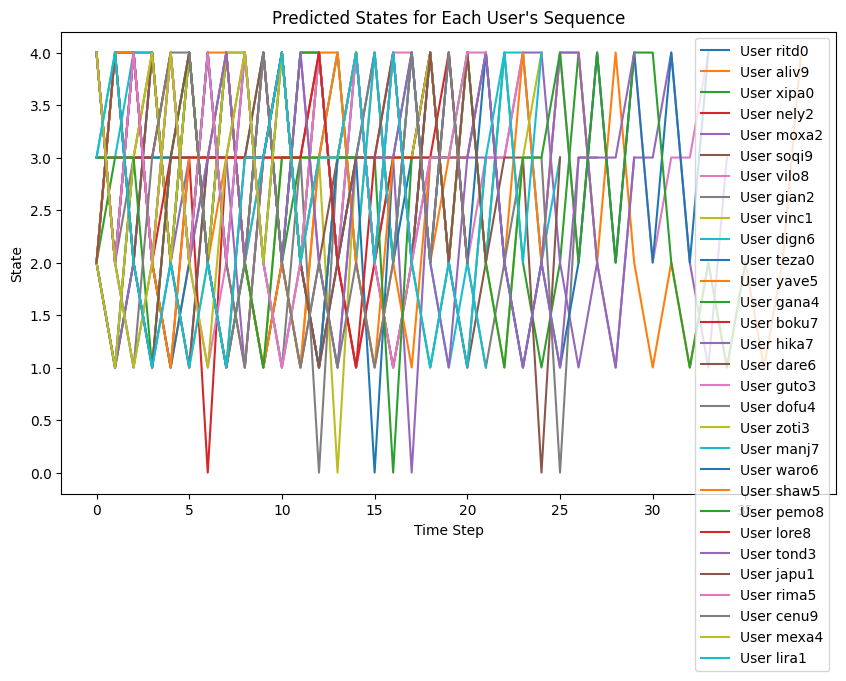

In [187]:
plt.figure(figsize=(10, 6))

for user, seq in all_encoded_sequences.items():
    reshaped = np.array(seq).reshape(-1, 1)
    scaled = scaler.transform(reshaped)

    # Predict the states for each observation
    states = model.predict(scaled)

    plt.plot(range(len(states)), states, label=f'User {user}')

plt.title("Predicted States for Each User's Sequence")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend(loc='best')
plt.show()

## Plot for Visualizing the HMM Learning Process

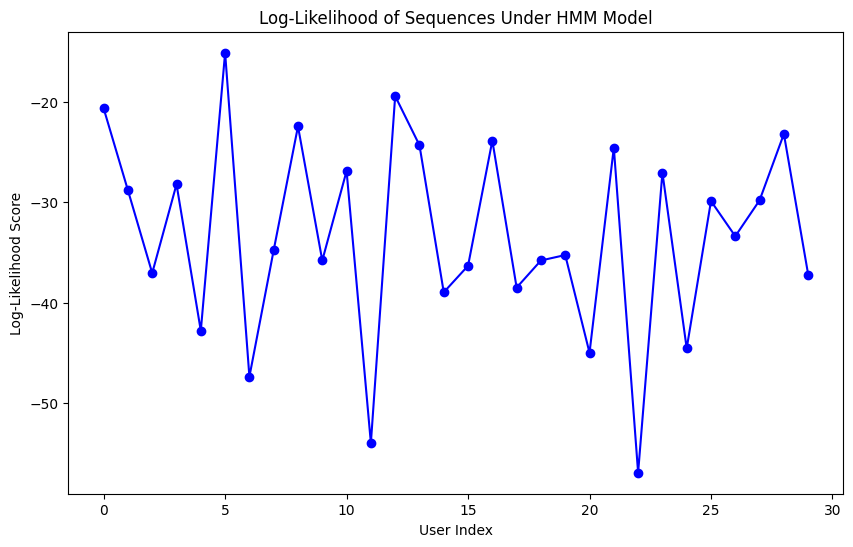

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods, marker='o', linestyle='-', color='b')
plt.title("Log-Likelihood of Sequences Under HMM Model")
plt.xlabel("User Index")
plt.ylabel("Log-Likelihood Score")
plt.show()

## Detect Anomalies Using Z-scores

In [186]:
# use z-scores to compare how unusual one sequence of events may be to the rest

scores = list(user_scores.values())
mean = statistics.mean(scores)
std = statistics.stdev(scores)

for user, score in user_scores.items():
    z = (score - mean) / std
    print(f"{user}: log-likelihood = {score:.2f}, z = {z:.2f}")
    if z < -1:
        print("SUSPICIOUS ACTIVITY DETECTED")

ritd0: log-likelihood = -20.66, z = 1.25
aliv9: log-likelihood = -28.81, z = 0.44
xipa0: log-likelihood = -37.05, z = -0.38
nely2: log-likelihood = -28.22, z = 0.50
moxa2: log-likelihood = -42.80, z = -0.94
soqi9: log-likelihood = -15.12, z = 1.80
vilo8: log-likelihood = -47.37, z = -1.40
SUSPICIOUS ACTIVITY DETECTED
gian2: log-likelihood = -34.77, z = -0.15
vinc1: log-likelihood = -22.45, z = 1.07
dign6: log-likelihood = -35.80, z = -0.25
teza0: log-likelihood = -26.89, z = 0.63
yave5: log-likelihood = -53.97, z = -2.05
SUSPICIOUS ACTIVITY DETECTED
gana4: log-likelihood = -19.43, z = 1.37
boku7: log-likelihood = -24.33, z = 0.89
hika7: log-likelihood = -38.97, z = -0.57
dare6: log-likelihood = -36.33, z = -0.30
guto3: log-likelihood = -23.87, z = 0.93
dofu4: log-likelihood = -38.50, z = -0.52
zoti3: log-likelihood = -35.80, z = -0.25
manj7: log-likelihood = -35.26, z = -0.20
waro6: log-likelihood = -44.99, z = -1.16
SUSPICIOUS ACTIVITY DETECTED
shaw5: log-likelihood = -24.57, z = 0.86